# Caso 1. Análisis de una fabricación de queso camembert usando `Python` y Google Colab.

En este ejercicio usaremos un fichero o archivo de datos en formato CSV que habremos exportado previamente desde nuestra hoja de cálculo. Más adelante aprenderemos cómo leer directamente los datos de nuestras hojas Excel.

[Abrir este cuaderno en Google Colab/](https://colab.research.google.com/github/juanriera/master-queseria/blob/master/040-caso1-camembert.ipynb)

[Descargar los datos de ejemplo `camembert.csv` usados en este cuaderno](https://raw.githubusercontent.com/juanriera/master-queseria/master/datos/camembert.csv)

## Flujo de trabajo

Coo vimos en el capítulo 2, es muy conveniente establecer un flujo de trabajo regular, de forma que cada etapa del análisis sea un paso que se apoye en los anteriores.

Este flujo de trabajo debe cubrir las etapas que veíamos en ese capítulo:

![](01-imagenes/data-science-explore.svg)

Vamos a ir desarrollando este flujo paso a paso.

### 1. Importar los datos

En este cuaderno vamos a cargar los datos desde GitHub; estos datos pueden ser descargados en el ordenador o Google Drive de cada uno, junto con el cuaderno, en los enlaces facilitados al principio. Una vez en Drive, puede leerse la tabla mediante el método que vimos al final del capítulo anterior.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

url_datos = 'https://raw.githubusercontent.com/juanriera/master-queseria/master/datos/camembert.csv'

try:
    df = pd.read_csv(url_datos, decimal = ",", sep=';', encoding='ISO-8859-1')
    print("¡Archivo ", url_datos," cargado correctamente!")
    print(f"Dimensiones de los datos: {df.shape}")
except Exception as e:
    print(f"Error al cargar el archivo: {e}")

¡Archivo  https://raw.githubusercontent.com/juanriera/master-queseria/master/datos/camembert.csv  cargado correctamente!
Dimensiones de los datos: (211, 7)


Vemos el `dataframe` que hemos leído, mediante la funcion `.head()`, que nos muestra las cinco primeras lineas.

In [2]:
df.head()

,fecha,fabricacion,est,mg,ph,cloruros,coliformes
0,11/01/2020,1,46.68,24.0,4.85,1.50,80.0
1,12/01/2020,1,48.09,25.0,4.67,1.61,0.0
2,13/01/2020,1,45.97,24.0,4.71,1.48,9200.0
3,14/01/2020,1,46.24,23.5,4.78,1.69,20.0
4,15/01/2020,1,45.81,23.0,4.77,1.56,150.0


Verificamos la estructura interna de nuestro `dataframe` y el tipo de los datos (entero, numérico, carácter...) mediante la función `.info()`

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211 entries, 0 to 210
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   fecha        211 non-null    object 
 1   fabricacion  211 non-null    int64  
 2   est          211 non-null    float64
 3   mg           211 non-null    float64
 4   ph           211 non-null    float64
 5   cloruros     211 non-null    float64
 6   coliformes   210 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 11.7+ KB


Como resultado de la importación el `csv`, la `fecha` aparece como columna `object`; nos interesa convertirla en un formato de fecha que `pandas` pueda reconocer

In [4]:
df['fecha'] = pd.to_datetime(
    df['fecha'], 
    format='%d/%m/%Y',  
    errors='coerce' # Si hay una fecha inválida, la convierte a 'NaT' (Not a Time) en lugar de fallar.
)

> Recuerda que si no comprendes bien el código, puedes copiarlo y pegarlo en Google Gemini y pedir a Gemini una explicación detallada de lo que hace.

Verificamos la conversión:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211 entries, 0 to 210
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   fecha        211 non-null    datetime64[ns]
 1   fabricacion  211 non-null    int64         
 2   est          211 non-null    float64       
 3   mg           211 non-null    float64       
 4   ph           211 non-null    float64       
 5   cloruros     211 non-null    float64       
 6   coliformes   210 non-null    float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 11.7 KB


Ahora la fecha tiene formato `datetime64` que es el formato de fecha que reconoce `pandas`.

### 2. Ordenar/limpiar los datos

La tabla de datos que hemos leído ya está en un formato *tidy*: una línea por observación y una columna por medida, como comprobamos inspeccionando las primera lineas de código:


In [6]:
df.head()

,fecha,fabricacion,est,mg,ph,cloruros,coliformes
0,2020-01-11,1,46.68,24.0,4.85,1.50,80.0
1,2020-01-12,1,48.09,25.0,4.67,1.61,0.0
2,2020-01-13,1,45.97,24.0,4.71,1.48,9200.0
3,2020-01-14,1,46.24,23.5,4.78,1.69,20.0
4,2020-01-15,1,45.81,23.0,4.77,1.56,150.0


Vamos entonces a verificar que los valores que hemos leído son correctos.
¿Qué tenemos que buscar?

* Valores mal introducidos que `Python`no tiene por qué saber que son erróneos (por ejemplo, un pH de 51,5 en vez de 5,15)
* Valores anormalmente altos o bajos, que pueden indicar errores de medida, de toma de muestras o de introducción de datos (por ejemplo, un pH de leche de 30, que puede indicar una lectura de temperatura introducida fuera de sitio)
* Valores erróneos: por ejemplo, valores negativos en cualquier medida
* Una distribucion de los datos anormal: 
    * por ejemplo, el pH de un queso debería tener la mayor frecuencia entorno al pH objetivo, y desviaciones con una frecuencia cada vez más baja a medida que se alejan del valor central
    * en cambio, los recuentos de bacterias coliformes deberían tener la mayor frecuencia en los valores cero o muy bajos, y la distribución no debería ser simétrica

En general, cualquier cosa que nos llame la atención en los datos y que debemos explicar.

Para hacer esta verificación, analizamos cada variable (columna) por separado.

#### Análisis de la variable `est`
Utilizamos las herramientas gráficas que conocemos: **histograma** y **diagrama de caja**. Por el momento no nos preocupamos de rotular el gráfico, estamos simplemente explorando rápidamente.

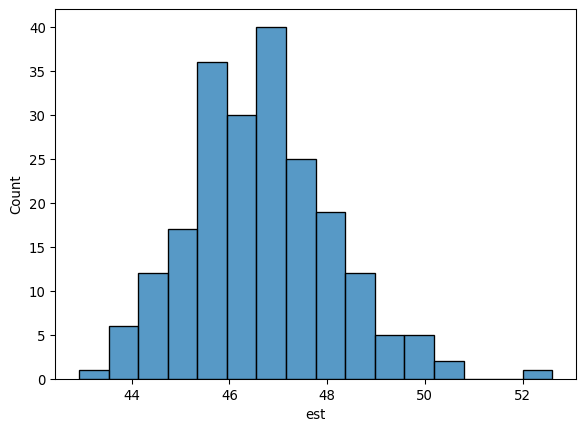

In [7]:
sns.histplot(df["est"])
plt.show()

El histograma nos muestra la mayor frecuencia en torno a 

## Introducción a los gráficos básicos

Una vez leído correctamente el `DataFrame`, podemos hacer algunos gráficos de sus columnas numéricas. También usaremos las funciones de `seaborn` que producen salidas muy atractivas y son funcionjes fáciles de manejar.

Exploremos los resultados de análisis de extracto seco total, recogidos en la variable `est` de nuestro `DataFrame`.

Para ello empezamos haciendo el histograma con `seaborn`, que nos permite incluir una **curva de densidad** fácilmente (pregunta: ¿qué es una curva de densidad?)

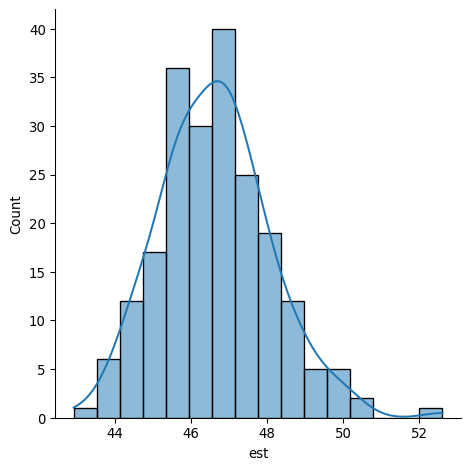

In [8]:
sns.displot(df["est"], kde = True)

plt.show()

Los histogramas nos muestran con claridad la **distribución** de los datos: los valores más frecuentes están entre 45% y 47%, y hay algún valor un poco más alto, por encima de 52%, que no parece que haya ocurrido muchas veces.

### El *boxplot*

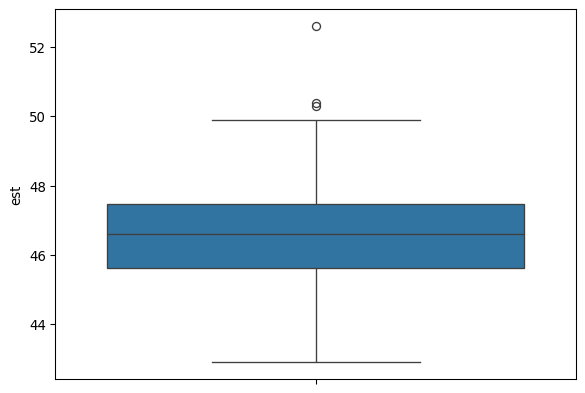

In [9]:
sns.boxplot(df['est'])

plt.show()

### Los gráficos de *series temporales*

En la celda en la que hemos obtenido la información del DataFrame con `df.info()`, veíamos que la columna `fecha` se lee como un `object`. En `Python`, un `object` es, por ejemplo, una cadena de caracteres. `Python` no tiene forma de saber que esto es una fecha, a menos que convirtamos explcícitamente el tipo de dato en fecha. Para ello, `Python` dispone de funciones muy sofisticadas que es muy conveniente conocer. Vamos, en primer lugar a dar el formato fecha a la columna, mediantela función 'Datetime

In [10]:

# Reemplazar la columna 'fecha' in-place
df['fecha'] = pd.to_datetime(
    df['fecha'], 
    format='%d/%m/%Y',
    errors='coerce' # Mantiene la robustez ante datos incorrectos
)

# Opcional: Verificar el cambio
print(df['fecha'].head())
print(df['fecha'].dtype)

0   2020-01-11
1   2020-01-12
2   2020-01-13
3   2020-01-14
4   2020-01-15
Name: fecha, dtype: datetime64[ns]
datetime64[ns]


Para representar los datos por mes, sólo tenemos que crear una nueva columna `mes` indicando a `pandas` que extraiga del índice la parte de fecha que corresponde al mes. ¿Fácil, no?

In [11]:
df['fecha_index']= pd.DatetimeIndex(df.fecha).normalize()
df.set_index('fecha_index',inplace=True)
df.sort_index(inplace=True)

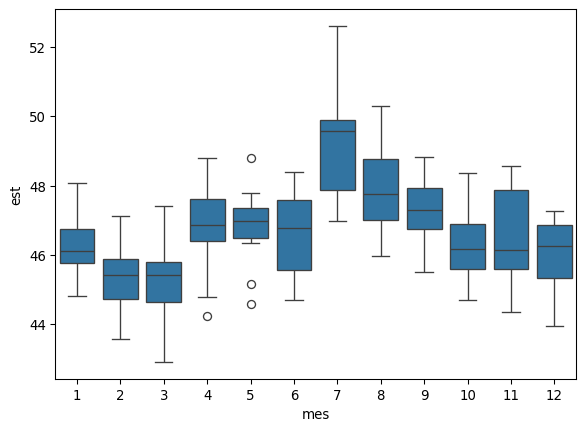

In [12]:
df['mes'] = df.index.month
sns.boxplot(x='mes', y='est', data=df)

plt.show()

En vez de usar el número para el mes, podemos usar el código de letras abreviado (en este caso, `seaborn`utiliza la abreviatura en inglés, pero hemos cambiado la codificación para que lo represente en español, en la instruccion `locale` que hemos usado en la primera casilla). Aprovechamos para personalizar un poco el gráfico.

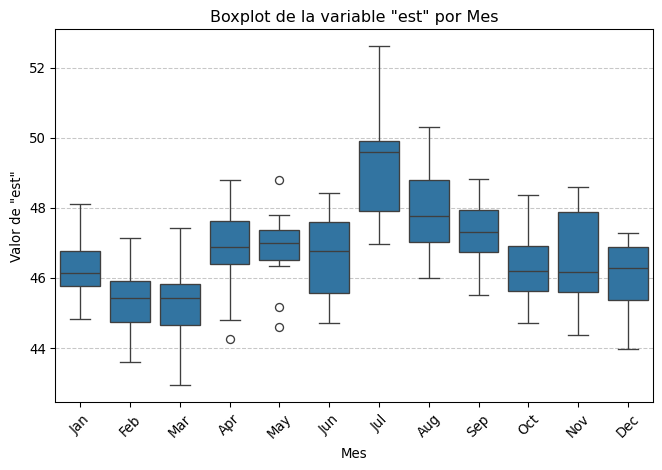

In [13]:
df['mes_abreviado'] = df.index.strftime('%b')
sns.boxplot(x='mes_abreviado', y='est', data=df)
# Opcional: Personalizar el gráfico
plt.title('Boxplot de la variable "est" por Mes')
plt.xlabel('Mes')
plt.ylabel('Valor de "est"')
plt.grid(axis='y', linestyle='--', alpha=0.7) # Añadir una cuadrícula para mejor lectura
plt.xticks(rotation=45) # Rotar las etiquetas del eje X si son muchas
plt.tight_layout() # Ajusta automáticamente los parámetros de la subtrama para un diseño ajustado

plt.show()


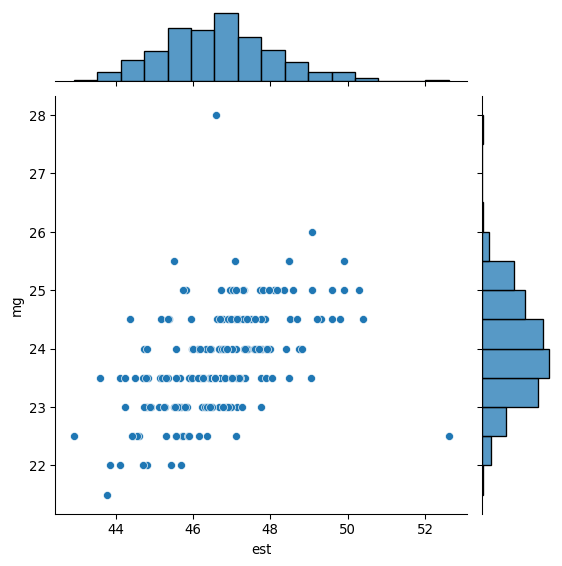

In [14]:
sns.jointplot(x="est", y="mg", data = df[~df.index.duplicated(keep='first')])

Finalmente, una serie de cálculos más complejos para obtener los gráficos de capacidad de un proceso, como muestra de cómo se pueden usar las funciones y gráficos de `Python` para prácticamente cualquier necesidad.

A continuación, una serie de celdas que realizan gráficos diversos, puedes dedicar un rato a estudiarlas e intentar comprender bien su programación.

In [15]:
df2 = df.copy()
df.drop(['fabricacion','mg', 'cloruros','coliformes'], axis=1, inplace = True)

In [16]:
df2 = df2['est'].groupby(df['fecha'].dt.isocalendar().week).agg(['mean','std'])

In [17]:
df2.head()

,mean,std
week,,
2,47.385000,0.997021
3,45.770000,0.547494
4,46.540000,0.893476
5,46.037778,0.493958
6,45.090000,1.252837


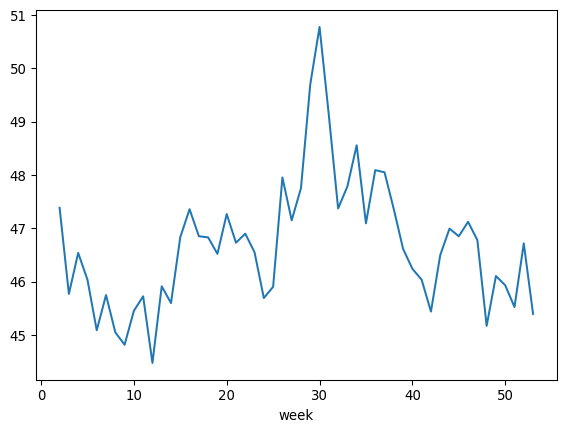

In [18]:
df2['mean'].plot();

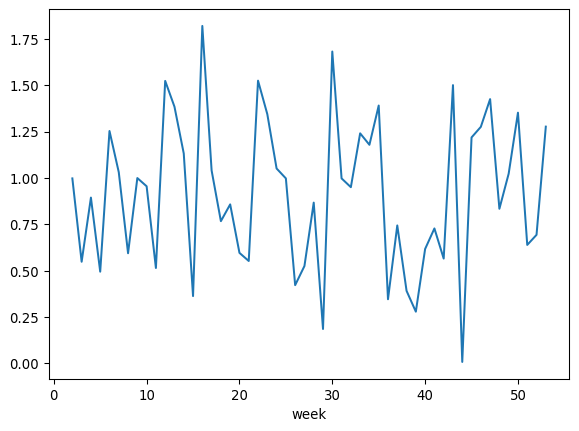

In [19]:
df2['std'].plot();

In [20]:
LSL = df2['mean'] - 3 * df2['std']    ## lower specification limit
USL = df2['mean'] + 3 * df2['std']    ## upper specification limit

df2.insert(2,'LSL', LSL)
df2.insert(3,'USL', USL)

# limite_rechazo = 231    ##
# limite_deficientes = 242    ##
# df3.insert(5,'rechazo', limite_rechazo)
# df3.insert(6,'deficientes', limite_deficientes)


In [21]:
df2.head()

,mean,std,LSL,USL
week,,,,
2,47.385000,0.997021,44.393938,50.376062
3,45.770000,0.547494,44.127517,47.412483
4,46.540000,0.893476,43.859571,49.220429
5,46.037778,0.493958,44.555904,47.519652
6,45.090000,1.252837,41.331490,48.848510


In [22]:
df2['semana'] = df2.index # necesitamos la semana en una columna de valor
df3 = pd.melt(df2, id_vars= ['semana'], value_vars=["mean","LSL", "USL"],  value_name="valores")

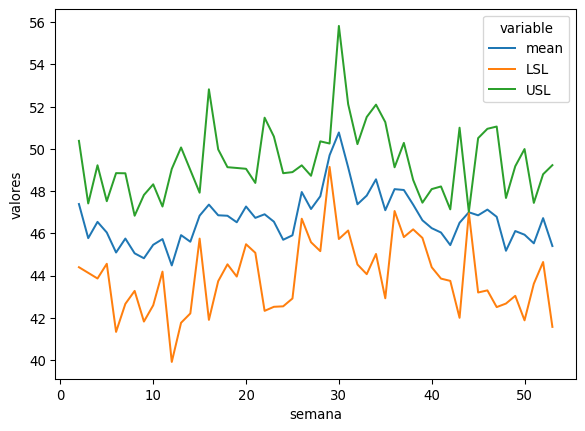

In [23]:
g = sns.lineplot(data=df3, x="semana", y="valores", hue="variable")

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

url_datos = 'https://raw.githubusercontent.com/juanriera/master-queseria/master/datos/camembert.csv'

try:
    df = pd.read_csv(url_datos, 
      decimal = ",", 
      sep=';', 
      encoding='ISO-8859-1')
except Exception as e:
    print(f"Error al cargar el archivo: {e}")

df['fecha'] = pd.to_datetime(
    df['fecha'], 
    format='%d/%m/%Y',  
    errors='coerce' # Si hay una fecha inválida, la convierte a 'NaT' (Not a Time) en lugar de fallar.
)

df['fecha_index']= pd.DatetimeIndex(df.fecha).normalize()
df.set_index('fecha_index',inplace=True)
df.sort_index(inplace=True)

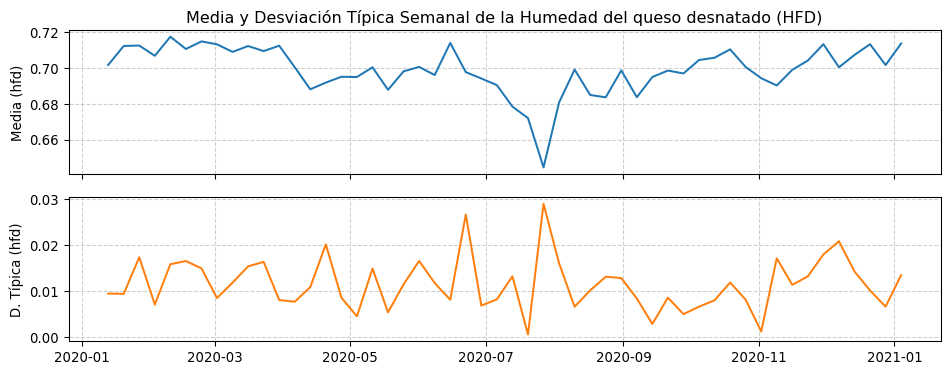

In [25]:
df["hfd"] = (100.0 - df['est']) / (100.0 - df['mg'])

# --- 1. Preparación de los datos (Calculando la Media y la Desviación Típica Semanal) ---
media_semanal = df["hfd"].resample('W-MON').mean()
dt_semanal = df["hfd"].resample('W-MON').std()

# --- 2. Creación de los Subgráficos (El paso clave) ---
# Creamos una figura (conjunto de gráficos) con 2 filas y 1 columna.
# El parámetro 'figsize=(10, 4)' controla el tamaño: 10 de ancho y 4 de alto total (como un gráfico normal).
# 'sharex=True' asegura que ambos gráficos compartan el mismo eje temporal.
fig, (ax1, ax2) = plt.subplots(
    nrows=2, 
    ncols=1, 
    figsize=(10, 4), 
    sharex=True
)

# --- 3. Graficar la Media (Gráfico Superior) ---
ax1.plot(media_semanal, label="Media Semanal", color='tab:blue')
ax1.set_title("Media y Desviación Típica Semanal de la Humedad del queso desnatado (HFD)")
ax1.set_ylabel("Media (hfd)")
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.tick_params(labelbottom=False) # Quita las etiquetas de fecha/hora del gráfico superior

# --- 4. Graficar la Desviación Típica (Gráfico Inferior) ---
ax2.plot(dt_semanal, label="Desviación Típica Semanal", color='tab:orange')
ax2.set_ylabel("D. Típica (hfd)")
ax2.grid(True, linestyle='--', alpha=0.6)

# Ajusta el espacio entre los gráficos para que no se superpongan
fig.tight_layout() 
plt.show()

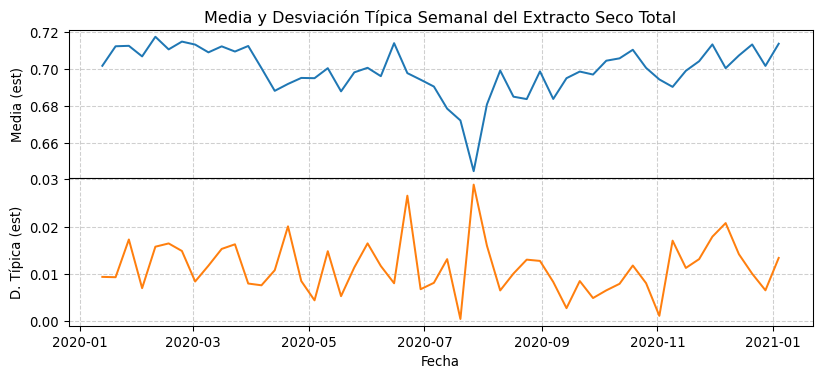

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Preparación de los datos (Usando tus variables ya calculadas) ---
# media_semanal = df["est"].resample('W-MON').mean()
# dt_semanal = df["est"].resample('W-MON').std()

# --- 2. Creación de los Subgráficos ---
fig, (ax1, ax2) = plt.subplots(
    nrows=2, 
    ncols=1, 
    figsize=(10, 4), 
    sharex=True
)

# --- 3. Graficar la Media (Gráfico Superior) ---
ax1.plot(media_semanal, label="Media Semanal", color='tab:blue')
ax1.set_title("Media y Desviación Típica Semanal del Extracto Seco Total")
ax1.set_ylabel("Media (est)")
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.tick_params(labelbottom=False) # ¡Importante! Oculta las etiquetas X en el gráfico superior

# --- 4. Graficar la Desviación Típica (Gráfico Inferior) ---
ax2.plot(dt_semanal, label="Desviación Típica Semanal", color='tab:orange')
ax2.set_ylabel("D. Típica (est)")
ax2.set_xlabel("Fecha") # Añadimos la etiqueta de fecha al gráfico inferior
ax2.grid(True, linestyle='--', alpha=0.6)

# --- 5. Ajuste para eliminar el espacio vertical (El paso clave) ---
plt.subplots_adjust(hspace=0) 

# Ajuste el espacio entre los gráficos para que no se superpongan
# Nota: 'tight_layout' puede interferir si no se ajusta con cuidado, por eso usamos plt.subplots_adjust
plt.show()